# **InceptionTime**

The family of time series classification models includes ensemble models. There are numerous such architectures including the state of the art Hive-Cote model. According to [1], the HIVE-COTE approach is extremely accurate, but cannot be applied to many real-world datasets because of its $O(N^{2}T^{4})$ training time. The paper claims it takes HIVE-COTE more than 8 days to learn from a small dataset with N = 1500 time series of short length T = 46.

It is possible to compute image transforms like Gramian Angular Fields or Markov Transition Fields and feed the outputs into an Inception model pre-trained for image recognition, which was what the Inception architecture was originally developed for.

The ensemble tested in this project is the InceptionTime model and it is based on the Inception architecture. It consists of 5 Inception networks, where each network consists of 6 blocks of 3 Inception modules, concluding with Global Average Pooling and a fully connected layer. The main idea of an Inception module is to incorporate different receptive field sizes to extract information on long and short term dependencies, something that is also the focus of this work.

The reason we use 5 Inception networks with identical architecture but different initialised weights is because an individual Inception network was shown to have a high standard deviation in accuracy, which the authors conjectured to come from the randomly initialised weights. Therefore, taking the average over 5 such weights reduces the instability through ensembling.

Each Inception module begins with a *bottleneck* layer which transforms the $M$ dimensional input to an $m$ dimensional output, where typically $m << M$, by sliding length 1 convolutional filters with a stride of 1 over the input. This allows InceptionTime to have longer filters while preserving approximately the same number of parameters to be learned. Moreover, 3 sets of 32 sliding filters, of lengths {10, 20, 40}, are applied simultaneously to the output of the bottleneck time series. Each module features a Max Pooling layer intended to make the model invariant to small perturbations. The outputs of each convolution/max pooling as well as the original input, which typically has dimension 32 are then concatenated to produce the output of the layer, which is therefore of dimension 128.

In [25]:
import os
import numpy as np
import pickle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.layers import Input, Layer, Conv1D, MaxPool1D, ReLU, BatchNormalization, Add, Dense, GlobalMaxPooling1D

In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

%run ../sys_configs.ipynb
%run ../plots.ipynb

Mounted at /content/drive


In [3]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [4]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.int32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.int32)
test_labels_tf = tf.one_hot(y_test, 31, dtype=tf.int32)

In [5]:
# Convert the dataset to tensors
train_data_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
val_data_tf = tf.convert_to_tensor(x_val, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tf, train_labels_tf))
val_ds = tf.data.Dataset.from_tensor_slices((val_data_tf, val_labels_tf))
test_ds = tf.data.Dataset.from_tensor_slices((test_data_tf, test_labels_tf))

In [7]:
train_ds = train_ds.shuffle(500)

train_ds = train_ds.padded_batch(64) # The paper uses a batch size of 64
val_ds = val_ds.padded_batch(64) # The paper uses a batch size of 64
test_ds = test_ds.padded_batch(16) # The paper uses a batch size of 16

In [8]:
C = len(set(y_train)) # Number of classes

### **Architecture**

We first define the Inception module, the building block of InceptionTime.

In [9]:
class InceptionModule(Layer):

    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.conv_bottleneck = Conv1D(self.num_filters, kernel_size=1, strides = 1, padding="same")
        self.conv_1 = Conv1D(self.num_filters, kernel_size=1, strides = 1, padding="same")
        self.conv_10 = Conv1D(self.num_filters, kernel_size=10, strides = 1, padding="same")
        self.conv_20 = Conv1D(self.num_filters, kernel_size=20, strides = 1, padding="same")
        self.conv_40 = Conv1D(self.num_filters, kernel_size=40, strides = 1, padding="same")

        self.relu = ReLU()
        self.batch_norm = BatchNormalization()

        self.max_pool = MaxPool1D(pool_size=3, strides=1, padding="same")

    def call(self, input):
        # Compute the bottleneck
        z = self.max_pool(input)
        z_bottleneck = self.conv_1(z)

        # This layer bypasses the bottleneck
        x_1 = self.conv_1(z)

        # These layers are computed using sliding convolutions over the bottleneck
        x_2 = self.conv_10(z_bottleneck)
        x_3 = self.conv_20(z_bottleneck)
        x_4 = self.conv_40(z_bottleneck)

        x = tf.concat([x_1, x_2, x_3, x_4], axis = 2)
        x = self.relu(x)
        output = self.batch_norm(x)

        return output

Next, define a custom shortcut layer that sums the input of a block and the output.

In [10]:
class ResidualLayer(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_tensor_shape, output_tensor_shape): # Tensorflow calls this method automatically when the object is defined
        self.conv = Conv1D(output_tensor_shape[-1], kernel_size=1, strides = 1, padding="same")
        self.batch_norm = BatchNormalization()
        self.add = Add()
        self.relu = ReLU()

    def call(self, input_tensor, output_tensor):
        # Compute the convolution and batch norm
        res = self.conv(input_tensor)
        res = self.batch_norm(res)

        # Add the output of the block to the residual
        x = self.add([output_tensor, res])
        output = self.relu(x)

        return output

Next, put together Inception modules to form the Inception network.

In [11]:
def InceptionTime(shape):
    block1_input_layer = Input(shape=shape)

    # The first block comprises 3 Inception layers and a residual link between the input and output of the block.
    layer = InceptionModule(num_filters = 32, name='InceptionModule1')(block1_input_layer)
    layer = InceptionModule(num_filters = 32, name='InceptionModule2')(layer)
    layer = InceptionModule(num_filters = 32, name='InceptionModule3')(layer)
    layer = ResidualLayer(name='ResidualLayer1')(block1_input_layer, layer)

    block2_input_layer = layer

    # The second block also comprises 3 Inception layers and a residual link between the input and output of the block.
    layer = InceptionModule(num_filters = 32, name='InceptionModule4')(layer)
    layer = InceptionModule(num_filters = 32, name='InceptionModule5')(layer)
    layer = InceptionModule(num_filters = 32, name='InceptionModule6')(layer)
    layer = ResidualLayer(name='ResidualLayer2')(block2_input_layer, layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [12]:
inceptionTime_model = InceptionTime(shape = (sz, dim))
inceptionTime_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule1          │ (None, 150, 128)       │         72,512 │ input_layer[0][0]      │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule2          │ (None, 150, 128)       │         76,416 │ InceptionModule1[0][0] │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule3          │ (None, 150, 128)       │         76,416 │ InceptionModule2[0][0] │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResidualLayer1            │ (None, 150, 128)       │          1,408 │ input_layer[0][0],     │
│ (ResidualLayer)           │                        │                │ InceptionModule3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule4          │ (None, 150, 128)       │         76,416 │ ResidualLayer1[0][0]   │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule5          │ (None, 150, 128)       │         76,416 │ InceptionModule4[0][0] │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ InceptionModule6          │ (None, 150, 128)       │         76,416 │ InceptionModule5[0][0] │
│ (InceptionModule)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResidualLayer2            │ (None, 150, 128)       │         17,024 │ ResidualLayer1[0][0],  │
│ (ResidualLayer)           │                        │                │ InceptionModule6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ ResidualLayer2[0][0]   │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 31)             │          3,999 │ global_max_pooling1d[… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 477,023 (1.82 MB)

 Trainable params: 474,975 (1.81 MB)

 Non-trainable params: 2,048 (8.00 KB)

The final class classification is an ensemble of 5 Inception models, so we now write code that can take the ensemble of the 5 fitted models.

In [13]:
# Number of models in the ensemble
n_models = 5

# List to store metrics for each model
model_metrics = []

for i in range(n_models):
    # We use early stopping as InceptionTime is a high parameter network, so requires many epochs to train.
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=15)

    # The paper also makes use of ReduceLROnPlateau which reduces the lesrning rate when the loss plateaus.
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=10e-3)

    inceptionTime_model = InceptionTime(shape = (sz, dim))
    inceptionTime_model.compile(optimizer=Adam(learning_rate=10e-2, beta_1=0.95, beta_2 = 0.99, epsilon=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])
    history = inceptionTime_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[earlystopping, reduce_lr])

    # Save model weights
    inceptionTime_model.save(f'../models/InceptionTime_model/inceptionTime_model_{i}.h5')
    with open(f'../models/InceptionTime_model/train_history_{i}.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    # Evaluate the model
    val_loss, val_acc = inceptionTime_model.evaluate(val_ds, batch_size=64)

    # Store the metrics
    model_metrics.append({'model': i, 'val_loss': val_loss, 'val_acc': val_acc})

# Print the collected metrics
for metrics in model_metrics:
    print(f"Model {metrics['model']}: Validation Loss={metrics['val_loss']}, Validation Accuracy={metrics['val_acc']}")

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.0979 - loss: 6.0765 - val_accuracy: 0.0970 - val_loss: 131.5167 - learning_rate: 0.1000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2257 - loss: 2.2137 - val_accuracy: 0.1753 - val_loss: 7.5119 - learning_rate: 0.1000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3519 - loss: 1.7854 - val_accuracy: 0.2687 - val_loss: 3.3933 - learning_rate: 0.1000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4284 - loss: 1.5383 - val_accuracy: 0.2392 - val_loss: 4.2675 - learning_rate: 0.1000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4417 - loss: 1.4312 - val_accuracy: 0.3254 - val_loss: 3.6727 - learning_rate: 0.1000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4928 - loss: 1.3275 - val_accuracy: 0.3240 - val_loss: 4.7550 - learning_rate: 0.1000
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5246 - loss: 1.2717 - val

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6204 - loss: 2.5432
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.0655 - loss: 6.8681 - val_accuracy: 0.0352 - val_loss: 119.3933 - learning_rate: 0.1000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0927 - loss: 3.1713 - val_accuracy: 0.0618 - val_loss: 8.8683 - learning_rate: 0.1000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1049 - loss: 2.9664 - val_accuracy: 0.1322 - val_loss: 2.8420 - learning_rate: 0.1000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2169 - loss: 2.4492 - val_accuracy: 0.1494 - val_loss: 4.2012 - learning_rate: 0.1000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2908 - loss: 2.0101 - val_accuracy: 0.1422 - val_loss: 5.2979 - learning_rate: 0.1000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3506 - loss: 1.7701 - val_accuracy: 0.2184 - val_loss: 4.1614 - learning_rate: 0.1000
Epoch 7/50
68/68 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6062 - loss: 2.2769
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.1212 - loss: 6.4704 - val_accuracy: 0.0517 - val_loss: 465.6628 - learning_rate: 0.1000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2985 - loss: 2.1102 - val_accuracy: 0.1207 - val_loss: 20.1741 - learning_rate: 0.1000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4038 - loss: 1.6241 - val_accuracy: 0.2953 - val_loss: 4.3334 - learning_rate: 0.1000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4686 - loss: 1.3945 - val_accuracy: 0.3341 - val_loss: 2.8856 - learning_rate: 0.1000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5321 - loss: 1.2079 - val_accuracy: 0.2665 - val_loss: 4.4887 - learning_rate: 0.1000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5579 - loss: 1.1322 - val_accuracy: 0.2328 - val_loss: 6.1169 - learning_rate: 0.1000
Epoch 7/50
68/68

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5876 - loss: 3.2133
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.1162 - loss: 6.3713 - val_accuracy: 0.0575 - val_loss: 248.0141 - learning_rate: 0.1000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2933 - loss: 2.0989 - val_accuracy: 0.1717 - val_loss: 13.3552 - learning_rate: 0.1000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3720 - loss: 1.6606 - val_accuracy: 0.3822 - val_loss: 2.6698 - learning_rate: 0.1000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4295 - loss: 1.5206 - val_accuracy: 0.3542 - val_loss: 4.0413 - learning_rate: 0.1000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4955 - loss: 1.3243 - val_accuracy: 0.3592 - val_loss: 3.6383 - learning_rate: 0.1000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5446 - loss: 1.1647 - val_accuracy: 0.3606 - val_loss: 4.3685 - learning_rate: 0.1000
Epoch 7/50
68/68

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5110 - loss: 3.5273
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.0811 - loss: 6.2483 - val_accuracy: 0.0718 - val_loss: 219.9324 - learning_rate: 0.1000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1843 - loss: 2.6710 - val_accuracy: 0.1178 - val_loss: 9.9790 - learning_rate: 0.1000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2807 - loss: 2.0988 - val_accuracy: 0.1372 - val_loss: 9.2065 - learning_rate: 0.1000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3701 - loss: 1.7907 - val_accuracy: 0.2356 - val_loss: 4.7076 - learning_rate: 0.1000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4269 - loss: 1.6026 - val_accuracy: 0.3671 - val_loss: 2.8375 - learning_rate: 0.1000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4616 - loss: 1.4385 - val_accuracy: 0.2773 - val_loss: 5.5893 - learning_rate: 0.1000
Epoch 7/50
68/68 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5874 - loss: 2.9252
Model 0: Validation Loss=2.6617367267608643, Validation Accuracy=0.6336206793785095
Model 1: Validation Loss=2.315080404281616, Validation Accuracy=0.6192528605461121
Model 2: Validation Loss=3.500429630279541, Validation Accuracy=0.5941091775894165
Model 3: Validation Loss=3.372450828552246, Validation Accuracy=0.5330459475517273
Model 4: Validation Loss=2.602738857269287, Validation Accuracy=0.6120689511299133


Next, we experiment with 2 approaches:

- Approach 1: Take the best performing model from the train process and continue the train process.

- Approach 2: Take an ensemble of the 5 models. The class prediction is the majority class across the 5 ensemble models.

In [21]:
# Load the model
models = []
history = []
custom_objects = {'InceptionModule': InceptionModule, 'ResidualLayer': ResidualLayer}

for i in range(5):
    model = load_model(f'../models/InceptionTime_model/inceptionTime_model_{i}.h5', custom_objects=custom_objects)
    models.append(model)

    # Load the training history
    with open(f'../models/InceptionTime_model/train_history_{i}.pkl', 'rb') as f:
        history.append(pickle.load(f))

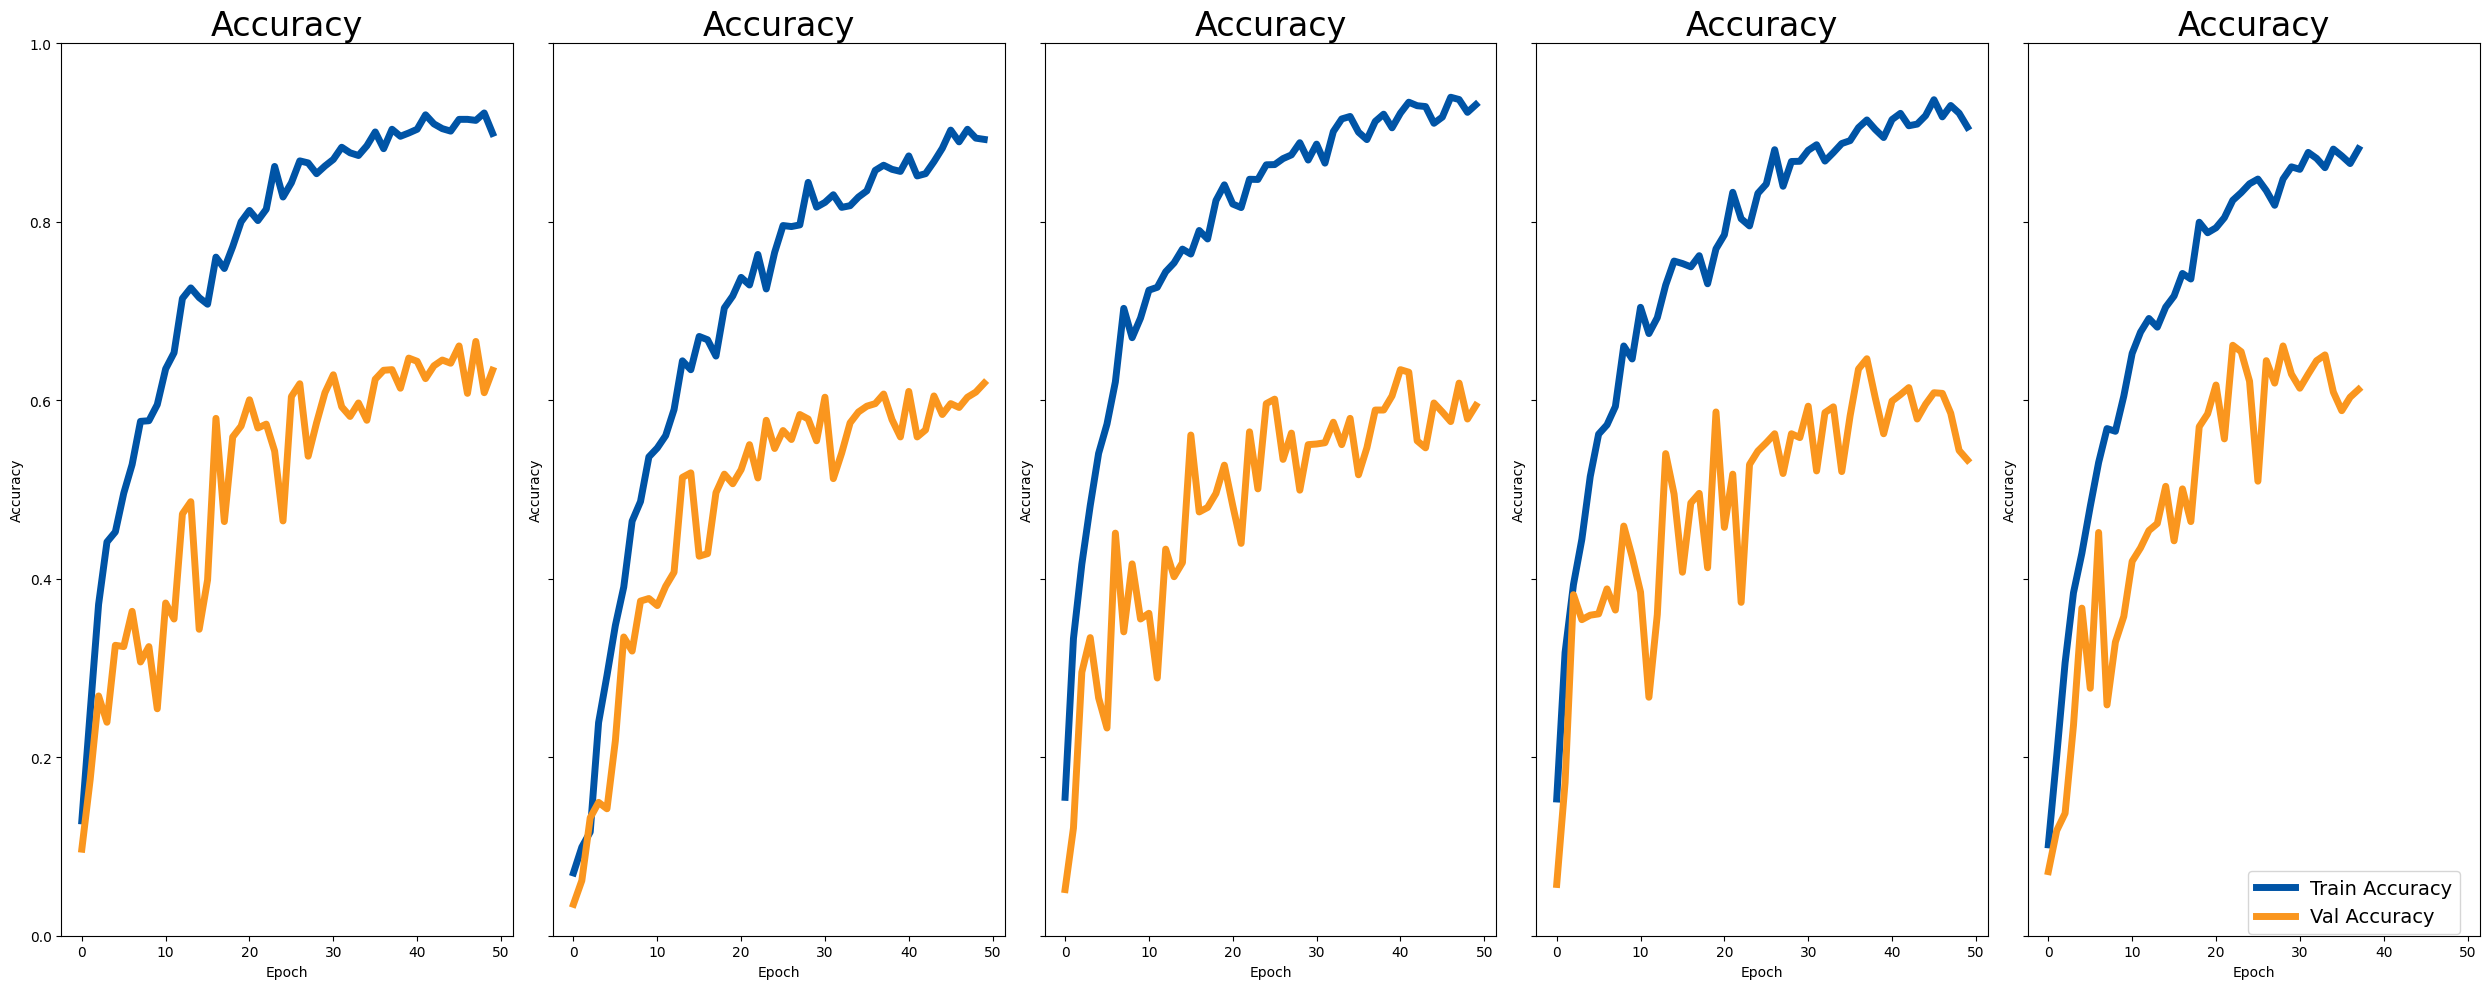

In [15]:
n_rows, n_cols = 1, 5
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey= True, figsize=(25,10))
fig.subplots_adjust(hspace=0.0, wspace=0.3)

for i in range(5):
    axes[i].plot(history[i]['accuracy'], color = scale_rgb(COLOURS.get("accent-blue-dark-3")), linewidth=5, markersize=50, label='Train Accuracy')
    axes[i].plot(history[i]['val_accuracy'], color = scale_rgb(COLOURS.get("accent-orange")), linewidth=5, markersize=50, label='Val Accuracy')
    axes[i].set_title("Accuracy", fontsize = 24)
    axes[i].set_ylim([0, 1])
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Accuracy")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.99, 0.05), fontsize=14)

plt.tight_layout()
plt.show()

#### **Approach 1**

The best performing model according to the visuals produced above was model 0.

In [16]:
best_train_eval = models[0].evaluate(train_ds, batch_size = 64)
best_val_eval = models[0].evaluate(val_ds, batch_size = 64)
best_test_eval = models[0].evaluate(test_ds, batch_size = 64)

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9112 - loss: 0.2792
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6204 - loss: 2.5432
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 3.7434


#### **Approach 2**

In this approach, the ensemble's class output probability is the logistic output averaged over the 5 models. This is the approach taken in the paper.

In [17]:
ensemble_train_predictions = []
ensemble_val_predictions = []
ensemble_test_predictions = []

for model in models:
    ensemble_train_predictions.append(model.predict(train_ds))
    ensemble_val_predictions.append(model.predict(val_ds))
    ensemble_test_predictions.append(model.predict(test_ds))

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [18]:
# Take the mean prediction over the 5 models
ensemble_train_predictions = np.mean(ensemble_train_predictions, axis=0)
ensemble_val_predictions = np.mean(ensemble_val_predictions, axis=0)
ensemble_test_predictions = np.mean(ensemble_test_predictions, axis=0)

In [19]:
# Find the class with the highest prediction probability across the 5 models, for each sample
ensemble_train_predicted_classes = np.argmax(ensemble_train_predictions, axis=1)
ensemble_val_predicted_classes = np.argmax(ensemble_val_predictions, axis=1)
ensemble_test_predicted_classes = np.argmax(ensemble_test_predictions, axis=1)

# Do the same for the one hot encoded labels.
ensemble_train_labels = np.argmax(train_labels_tf, axis=1)
ensemble_val_labels = np.argmax(val_labels_tf, axis=1)
ensemble_test_labels = np.argmax(test_labels_tf, axis=1)

In [20]:
print(f"Train Accuracy {np.equal(ensemble_train_predicted_classes, ensemble_train_labels).mean()}")
print(f"Validation Accuracy {np.equal(ensemble_val_predicted_classes, ensemble_val_labels).mean()}")
print(f"Test Accuracy {np.equal(ensemble_test_predicted_classes, ensemble_test_labels).mean()}")

Train Accuracy 0.031712962962962964
Validation Accuracy 0.7341954022988506
Test Accuracy 0.7193149381541389


Observe that the train accuracy reduces to near 0, as each ensemble model is overfit. However, the validation accuracy is competitive with the best model in approach 1.

### **Visualise predictions for test set**

In [22]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(ensemble_val_predicted_classes), sum(np.equal(ensemble_val_predicted_classes, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(ensemble_test_predicted_classes), sum(np.equal(ensemble_test_predicted_classes, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1022
Test Data - Total predictions made: 1051. Number of correct predictions: 756


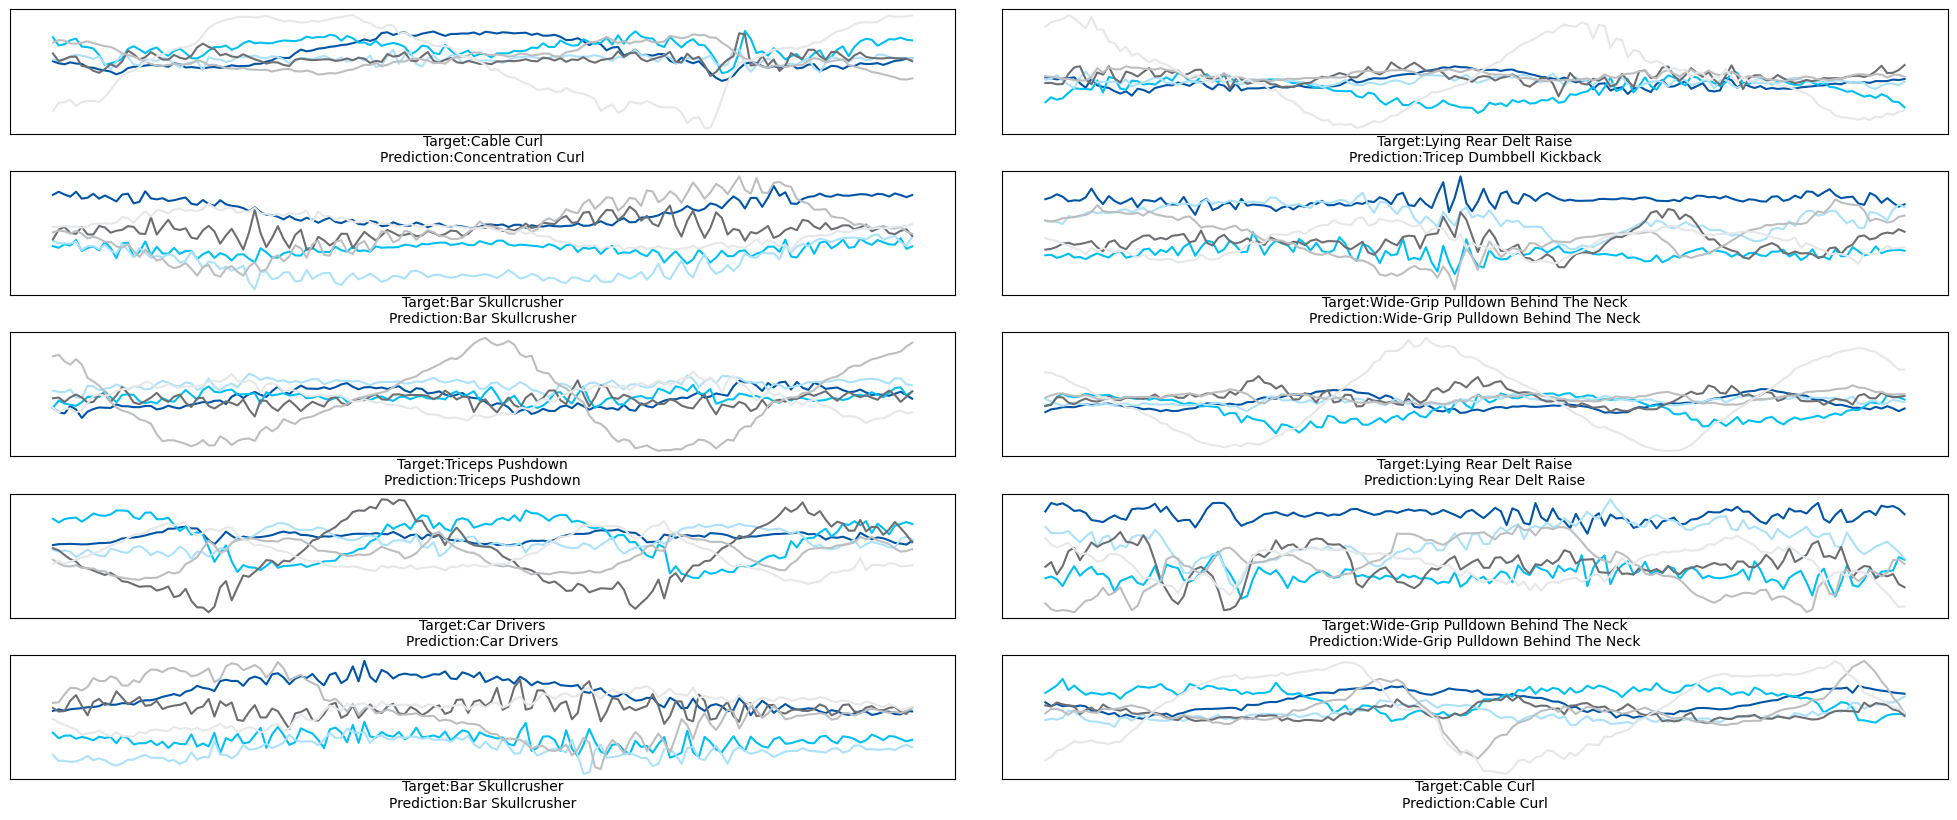

In [23]:
plot_samples(data = x_test, labels = y_test, predictions = ensemble_test_predicted_classes)

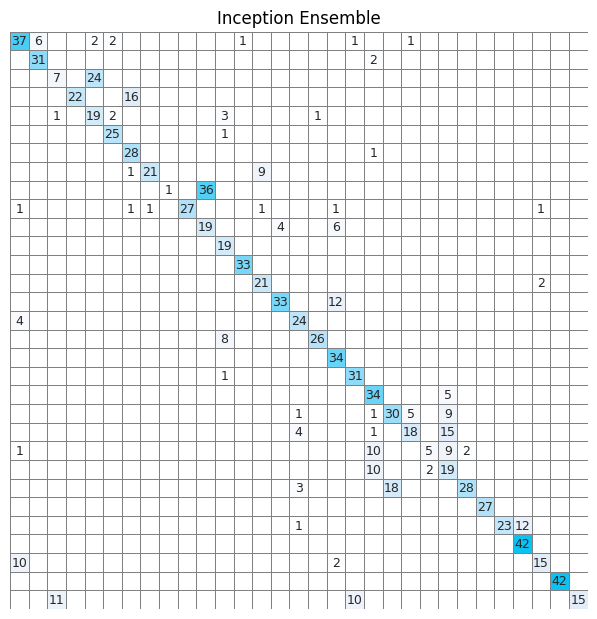

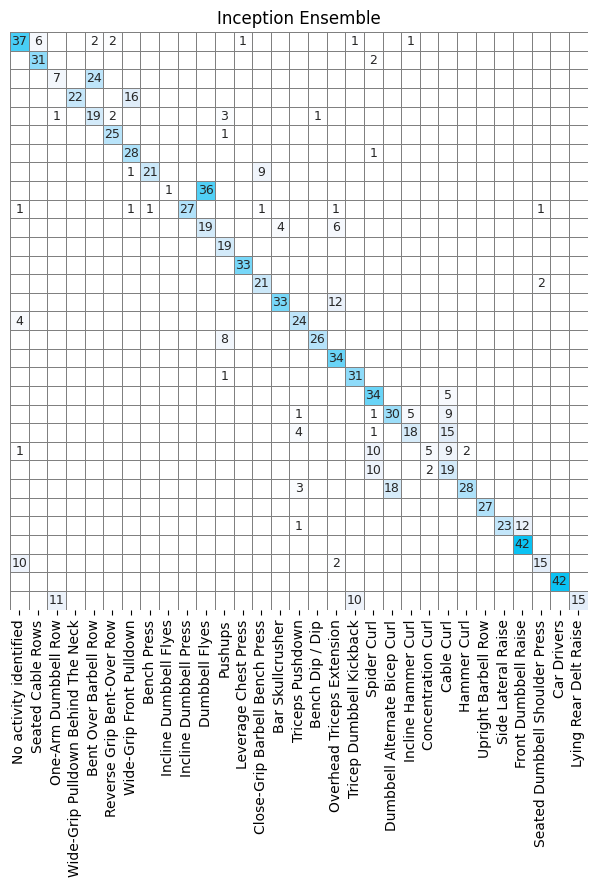

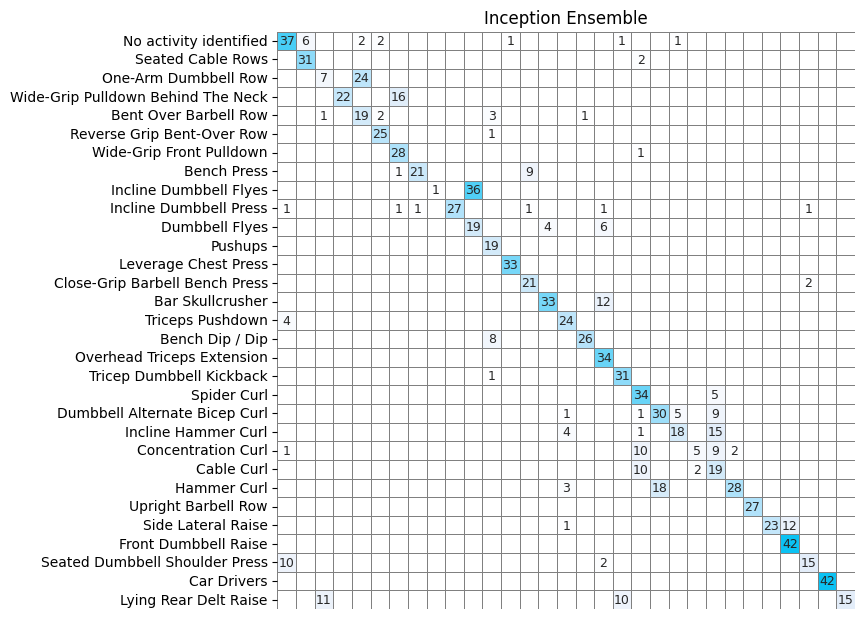

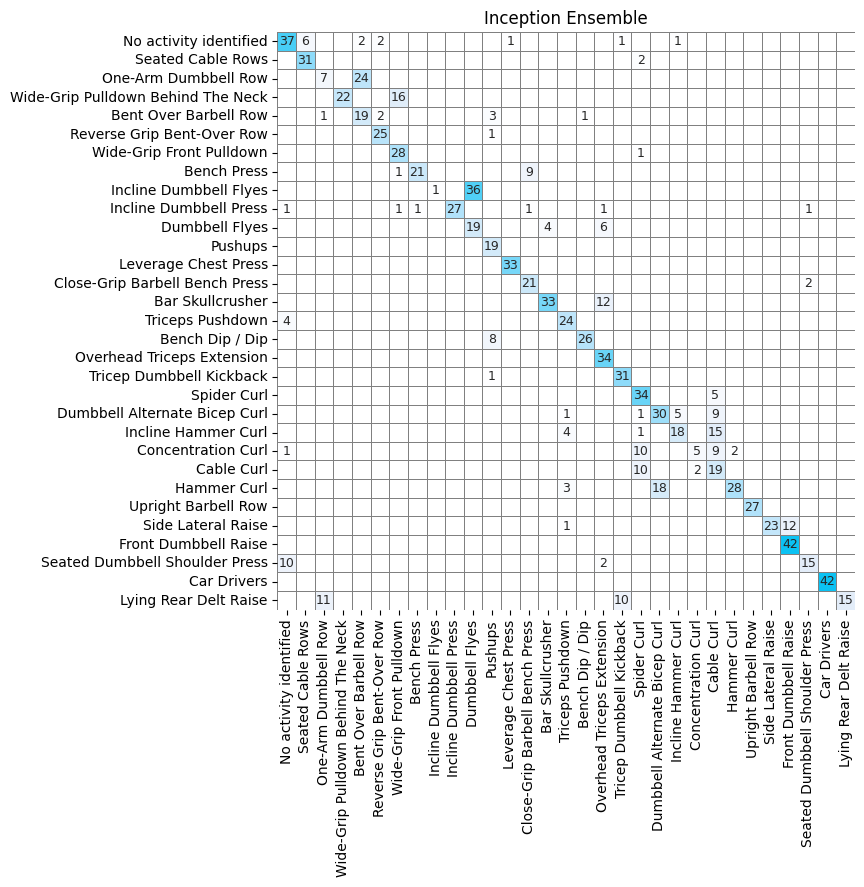

In [26]:
cm = confusion_matrix(y_test, ensemble_test_predicted_classes, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm, x_ticks = False, y_ticks = False, save = True, title = "Inception Ensemble")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = False, save = True, title = "Inception Ensemble")
plot_confusion_matrix(cm, x_ticks = False, y_ticks = True, save = True, title = "Inception Ensemble")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = True, save = True, title = "Inception Ensemble")

## **References**

[1] Ismail Fawaz, Hassan, Benjamin Lucas, Germain Forestier, Charlotte Pelletier, Daniel F. Schmidt, Jonathan Weber, Geoffrey I. Webb, Lhassane Idoumghar, Pierre-Alain Muller and Franccois Petitjean. “InceptionTime: Finding AlexNet for time series classification.” Data Mining and Knowledge Discovery 34 (2019): 1936 - 1962.